In [2]:
!unzip "../model-classification-coffee-leaf/dataset_tensorflow.zip" -d ../model-classification-coffee-leaf

Archive:  ../model-classification-coffee-leaf/dataset_tensorflow.zip
   creating: ../model-classification-coffee-leaf/dataset_tensorflow/
   creating: ../model-classification-coffee-leaf/dataset_tensorflow/test/
   creating: ../model-classification-coffee-leaf/dataset_tensorflow/test/miner/
  inflating: ../model-classification-coffee-leaf/dataset_tensorflow/test/miner/1100.jpg  
  inflating: ../model-classification-coffee-leaf/dataset_tensorflow/test/miner/1101.jpg  
  inflating: ../model-classification-coffee-leaf/dataset_tensorflow/test/miner/1102.jpg  
  inflating: ../model-classification-coffee-leaf/dataset_tensorflow/test/miner/1103.jpg  
  inflating: ../model-classification-coffee-leaf/dataset_tensorflow/test/miner/1104.jpg  
  inflating: ../model-classification-coffee-leaf/dataset_tensorflow/test/miner/1105.jpg  
  inflating: ../model-classification-coffee-leaf/dataset_tensorflow/test/miner/1106.jpg  
  inflating: ../model-classification-coffee-leaf/dataset_tensorflow/test/miner

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, Resizing
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE_X = 256
IMAGE_SIZE_Y =256
CHANNELS=3
EPOCHS=30

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../model-classification-coffee-leaf/dataset_tensorflow/train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE_X, IMAGE_SIZE_Y),
    batch_size=BATCH_SIZE
)

Found 1264 files belonging to 4 classes.


In [4]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [5]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [6]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [7]:
resize_and_rescale = tf.keras.Sequential([
    Resizing(IMAGE_SIZE_X, IMAGE_SIZE_Y),
    Rescaling(1./255),
])

In [8]:
data_augmentation = tf.keras.Sequential([
  RandomFlip("horizontal_and_vertical"),
  RandomRotation(0.2),
])

In [9]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
CHANNELS = 3

input_shape = (BATCH_SIZE, IMAGE_SIZE_X, IMAGE_SIZE_Y, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

d:\Maestria\2-Cursos\9-TFM\Recursos\Fuente\model-classification-coffee-leaf\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 4)                │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,812 (718.02 KB)

 Trainable params: 183,812 (718.02 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 222ms/step - accuracy: 0.2850 - loss: 1.3735 - val_accuracy: 0.3125 - val_loss: 1.3268
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step - accuracy: 0.3536 - loss: 1.2703 - val_accuracy: 0.5078 - val_loss: 1.0973
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - accuracy: 0.5252 - loss: 1.0601 - val_accuracy: 0.6406 - val_loss: 0.8205
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step - accuracy: 0.6406 - loss: 0.8690 - val_accuracy: 0.6641 - val_loss: 0.7548
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 206ms/step - accuracy: 0.6823 - loss: 0.7166 - val_accuracy: 0.7812 - val_loss: 0.6597
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 206ms/step - accuracy: 0.8417 - loss: 0.4286 - val_accuracy: 0.8281 - val_loss: 0.4767
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - accuracy: 0.8039 - loss: 0.4759 - val_accuracy: 0.8047 - val_loss: 0.5505
Epoch 8/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - accuracy: 0.8725 - loss: 0.3568 - val_accuracy: 0.

In [14]:
scores = model.evaluate(test_ds)
scores

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9833 - loss: 0.0464


[0.048006877303123474, 0.984375]

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

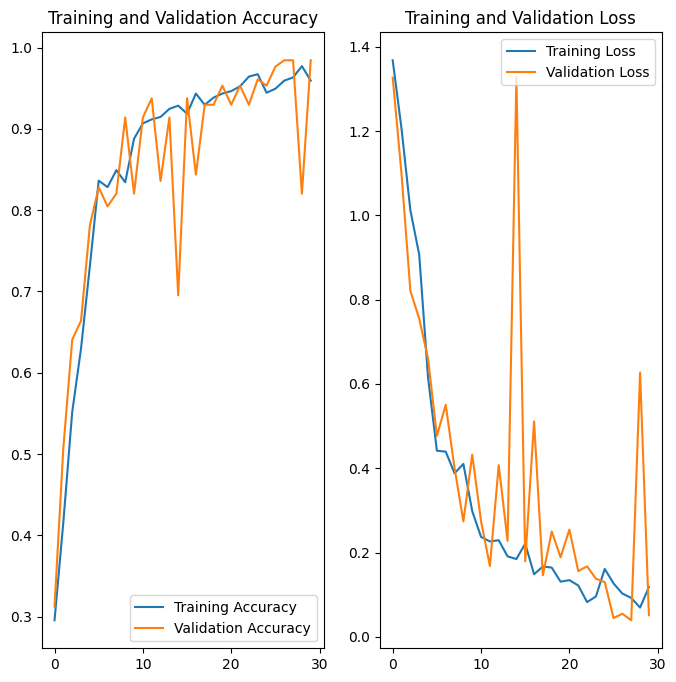

In [17]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(30), acc, label='Training Accuracy')
plt.plot(range(30), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(30), loss, label='Training Loss')
plt.plot(range(30), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: phoma
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
predicted label: phoma


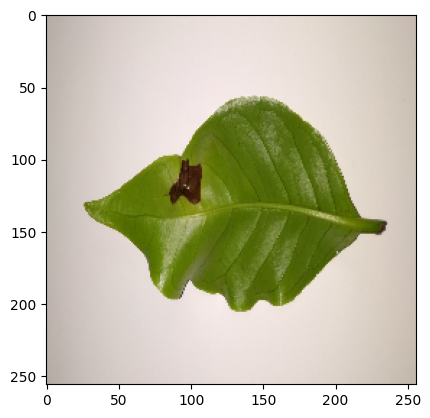

In [18]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    class_names = dataset.class_names
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [19]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


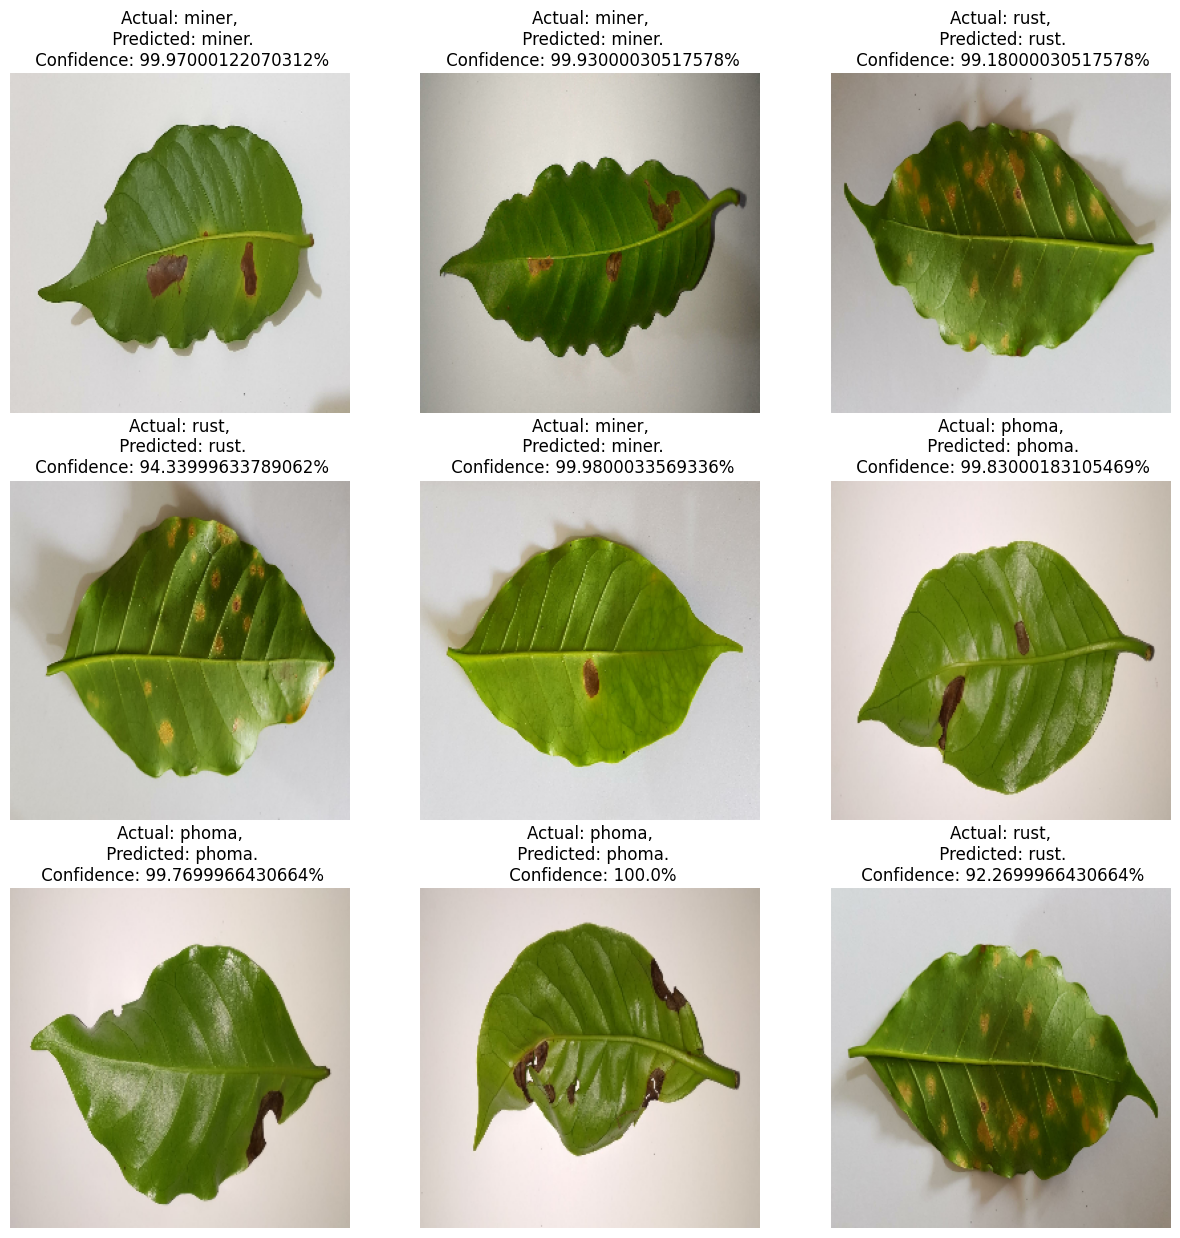

In [20]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [21]:
model_version = 10
model.save("../model-classification-coffee-leaf/models/model_tensorflow_{}.h5".format(model_version))
model.save("../model-classification-coffee-leaf/models/model_tensorflow_{}.keras".format(model_version))

# **Pruebas al modelo**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


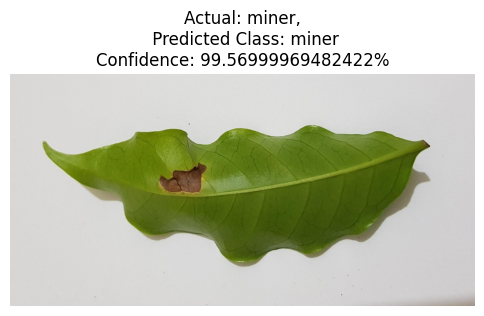

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


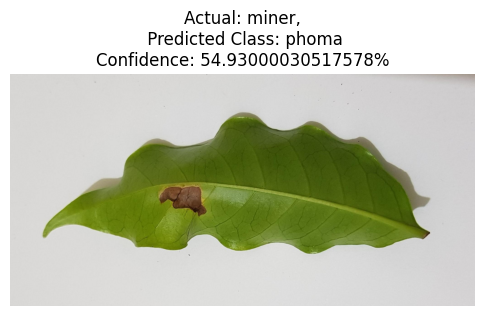

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


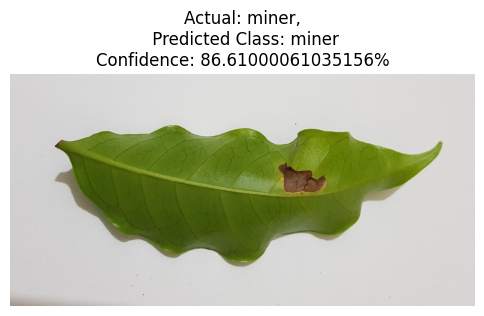

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


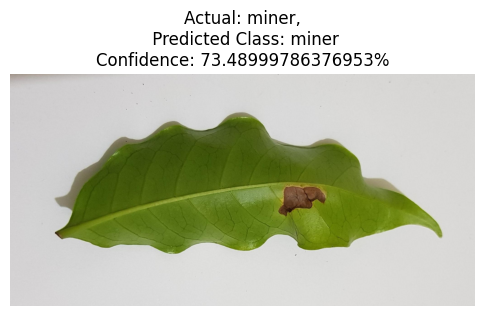

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


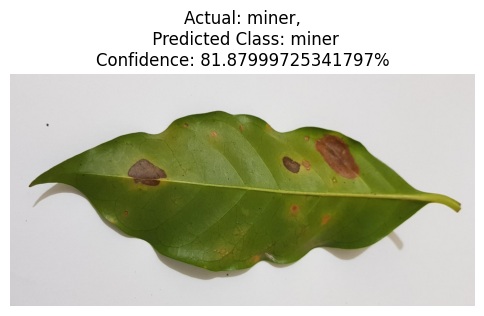

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


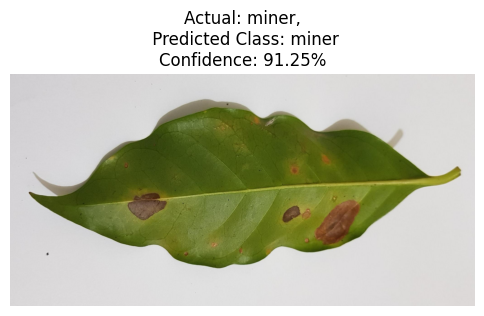

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


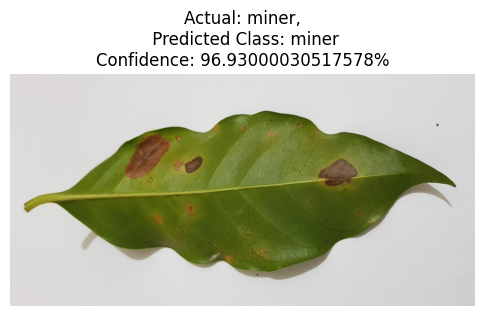

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


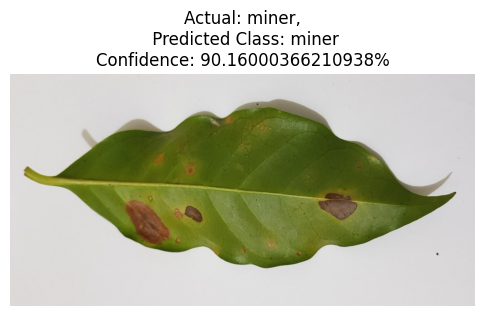

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


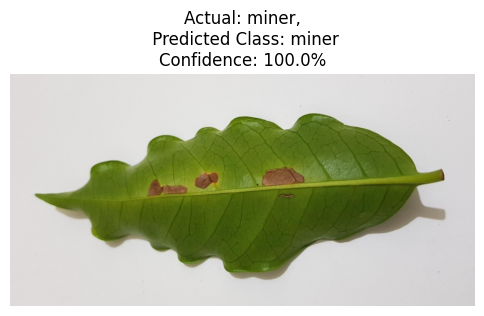

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


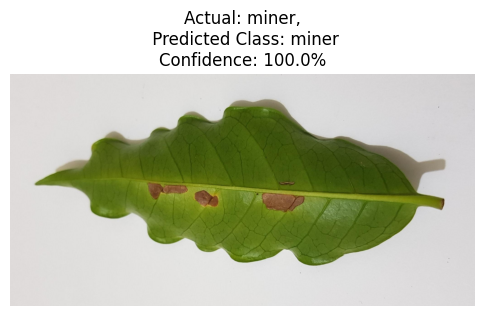

In [23]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def predict(model, img_path, class_names):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)

    return predicted_class, confidence


model = tf.keras.models.load_model(r"../model-classification-coffee-leaf/models/model_tensorflow_10.keras")


class_names = ['miner', 'nodisease', 'phoma', 'rust']


miner ="../model-classification-coffee-leaf/dataset_tensorflow/test/miner"
nodisease= "../model-classification-coffee-leaf/dataset_tensorflow/test/nodisease"
phoma="../model-classification-coffee-leaf/dataset_tensorflow/test/phoma"
rust="../model-classification-coffee-leaf/dataset_tensorflow/test/rust"

max_iterations=10
def classificator(image_dirteste,actual_class,max_iterations):

    iteration_count = 0
    image_dirteste = image_dirteste
    for filename in os.listdir(image_dirteste):

            if filename.endswith('.jpg'):

                image_path = os.path.join(image_dirteste, filename)


                predicted_class, confidence = predict(model, image_path, class_names)
                Actual: {actual_class}

                plt.figure(figsize=(6, 6))
                img = plt.imread(image_path)
                plt.imshow(img)
                plt.title(f"Actual: {actual_class},\n Predicted Class: {predicted_class}\nConfidence: {confidence}%")
                plt.axis('off')
                plt.show()

                iteration_count += 1


            if iteration_count >= max_iterations:
                break


classificator(miner,'miner',10)